# Exploratory data analysis
[dataset](http://snap.stanford.edu/data/higgs-activity_time.txt.gz)

## Import the needed libraries
 * **numpy**: widely used scientific computing package
 * **pandas**: library to deal with data frames
 * **datetime**: provides tools to deal with dates and timestamps
 * **seaborn**: visualization library on top of matplotlib

In [2]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import time
import os
from operator import itemgetter

% matplotlib inline

## Load the dataset

In [3]:
higgs_df = pd.read_csv('higgs-activity_time.txt', 
                       delim_whitespace=True, 
                       header=None, 
                       names=['user_a', 
                              'user_b', 
                              'timestamp', 
                              'interaction'])

Create column with datetime derived from the timestamp:

In [4]:
higgs_df['datetime'] = pd.to_datetime(higgs_df['timestamp'], unit='s')

In [5]:
higgs_df.shape

(563069, 5)

So we have a total of 563069 interactions.
Lets see how this count is distributed by interaction type:

Note:
 * **MT**: Mention
 * **RE**: Reply
 * **RT**: Retweet (forward)

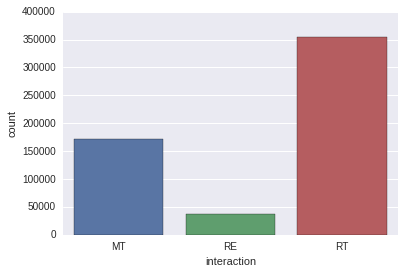

In [6]:
sns.countplot(data=higgs_df, x='interaction')

## Visualize the distribution of tweets through time

In [7]:
timestamp_min = higgs_df['datetime'].min()
timestamp_min

Timestamp('2012-07-01 00:02:52')

In [8]:
timestamp_max = higgs_df['datetime'].max()
timestamp_max

Timestamp('2012-07-07 23:59:53')

The data ranges from 2011-07-01 to 2012-07-07.

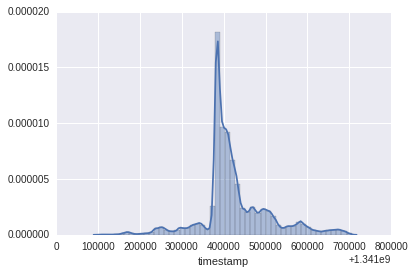

In [13]:
a = sns.distplot(higgs_df['timestamp'])

The spike in tweets should be correlated with the time Higgs boson was discovered.

In [9]:
time_hist = np.histogram(higgs_df['timestamp'], bins=100)
timestamp_max_interactions = np.floor(
    time_hist[1][np.argmax(time_hist[0])])
timestamp_max_interactions

1341379097.0

In [75]:
datetime_max_interactions = (
    higgs_df['datetime']
    [higgs_df['timestamp'] == timestamp_max_interactions]
    .unique())

print(datetime_max_interactions)

['2012-07-04T05:18:17.000000000']


The peak in interactions corresponds to 2012-07-04. Therefore, data was recorded in a range of plus and minus 3 days from the discovery.

It is also useful to plot 

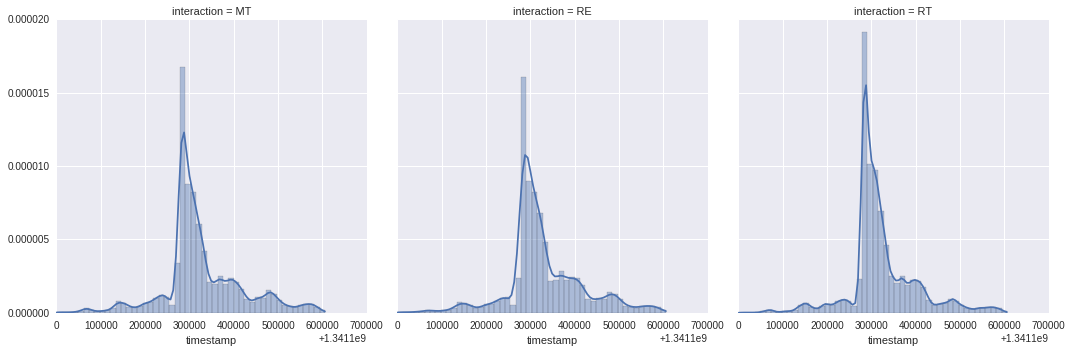

In [11]:
g = sns.FacetGrid(higgs_df, col='interaction', size=5)
g.map(sns.distplot, 'timestamp')

The distributions are quite similar across interaction types.

## General graph analysis

The following plot corresponds to the distribution of interactions per source user, and the following one for the target ones.

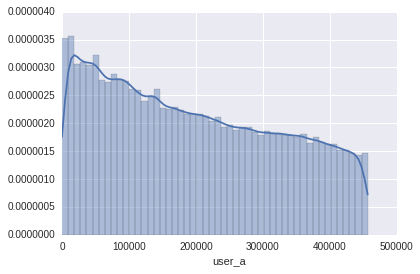

In [12]:
sns.distplot(higgs_df['user_a'])

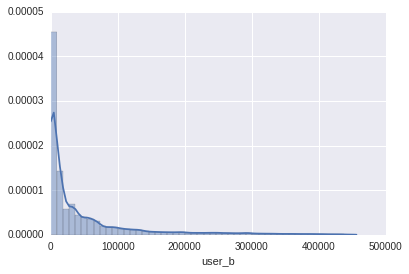

In [13]:
sns.distplot(higgs_df['user_b'])

# Data preparation

shape: (steps, interaction)

In [14]:
higgs_reindexed = higgs_df.set_index('timestamp').sort_index()

In [15]:
higgs_reindexed.head()

,user_a,user_b,interaction,datetime
timestamp,,,,
1341100972,223789,213163,MT,2012-07-01 00:02:52
1341100972,223789,213163,RE,2012-07-01 00:02:52
1341101181,376989,50329,RT,2012-07-01 00:06:21
1341101183,26375,168366,MT,2012-07-01 00:06:23
1341101192,376989,13813,RT,2012-07-01 00:06:32


In [16]:
higgs_one_hot = higgs_reindexed.drop('datetime', axis=1)
higgs_one_hot = pd.get_dummies(higgs_one_hot, columns=['interaction'])

higgs_one_hot.head()

,user_a,user_b,interaction_MT,interaction_RE,interaction_RT
timestamp,,,,,
1341100972,223789,213163,1.0,0.0,0.0
1341100972,223789,213163,0.0,1.0,0.0
1341101181,376989,50329,0.0,0.0,1.0
1341101183,26375,168366,1.0,0.0,0.0
1341101192,376989,13813,0.0,0.0,1.0


## Build User Dictionaries

In [17]:
unique_users = pd.concat([higgs_one_hot['user_a'], higgs_one_hot['user_b']]).unique()

In [18]:
num_users = len(unique_users)

In [19]:
idx2user = list(unique_users)
user2idx = {u: i for i, u in enumerate(idx2user)}

## And convert the original ids to the new ones

In [20]:
higgs_converted = higgs_one_hot.copy()

higgs_converted['user_a'] = higgs_converted['user_a'].apply(lambda u : user2idx[u])
higgs_converted['user_b'] = higgs_converted['user_b'].apply(lambda u : user2idx[u])

higgs_converted.head()

,user_a,user_b,interaction_MT,interaction_RE,interaction_RT
timestamp,,,,,
1341100972,0,50,1.0,0.0,0.0
1341100972,0,50,0.0,1.0,0.0
1341101181,1,279379,0.0,0.0,1.0
1341101183,2,279380,1.0,0.0,0.0
1341101192,1,54259,0.0,0.0,1.0


In [73]:
num_users

304691

## Obtain train, validation and test sets

In [21]:
test_idx = int(len(higgs_converted) * 0.8)
higgs_test = higgs_converted.iloc[test_idx:]

In [22]:
valid_idx = int(test_idx * 0.8)
higgs_valid = higgs_converted.iloc[valid_idx:test_idx]

In [23]:
higgs_train = higgs_converted.iloc[:valid_idx]

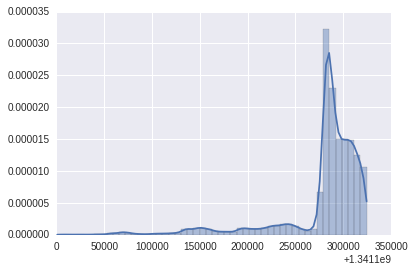

In [24]:
sns.distplot(higgs_train.index.values)

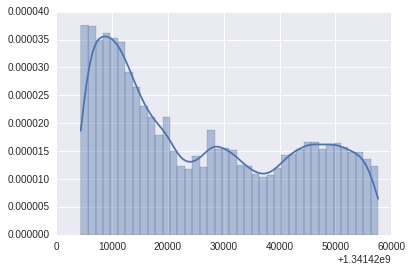

In [25]:
sns.distplot(higgs_valid.index.values)

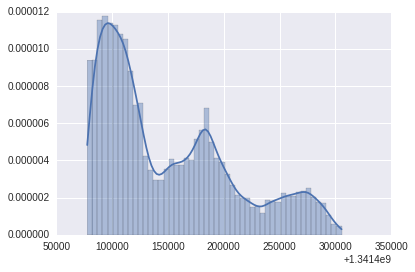

In [26]:
sns.distplot(higgs_test.index.values)

## Define features and labels

In [27]:
features = ['user_a']#, 'interaction_MT', 'interaction_RE', 'interaction_RT']
labels = ['user_b']

# Long Short-Term Memory Network

In [28]:
import tensorflow as tf

## Parameters

In [29]:
learning_rate = 0.001
num_epochs = 10
batch_size = 20
num_steps = 20
display_step = 10

## Network parameters

In [30]:
is_training = True

num_input = 4
num_hidden = 200
num_embedding = num_hidden
num_layers = 2
keep_prob = 1.0

## tf Graph input

In [31]:
x = tf.placeholder(tf.int32, [batch_size, num_steps])

In [32]:
y = tf.placeholder(tf.int32, [batch_size, num_steps])

In [33]:
global_step = tf.Variable(0, name='global_step', trainable=False)

## Create LSTM cell

In [34]:
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_hidden, forget_bias=0.0)

In [35]:
cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * num_layers)

In [36]:
initial_state = cell.zero_state(batch_size, tf.float32)

## Create embeddings for users

In [37]:
with tf.device('/cpu:0'):
    embedding = tf.Variable(tf.random_uniform([num_users, num_embedding]), name="embedding")
    embed = tf.nn.embedding_lookup(embedding, x)

## Prepare the inputs tensor for LSTM

In [39]:
inputs = tf.transpose(embed, [1, 0, 2])
inputs = tf.split(0, num_steps, inputs)
inputs = [tf.squeeze(i) for i in inputs]

## Define the forward pass

In [40]:
outputs, state = tf.nn.rnn(cell, inputs, initial_state=initial_state)

In [41]:
outputs = tf.reshape(tf.concat(1, outputs), [-1, num_hidden])

In [42]:
softmax_w = tf.Variable(tf.random_normal([num_hidden, num_users]), name='softmax_w')
softmax_b = tf.Variable(tf.zeros([num_users]), name='softmax_b')

In [43]:
logits = tf.nn.bias_add(tf.matmul(outputs, softmax_w), softmax_b)

## Compute loss

In [44]:
loss = tf.nn.seq2seq.sequence_loss_by_example([logits], 
                                              [tf.reshape(y, [-1])],
                                              [tf.ones([batch_size * num_steps])])

In [45]:
cost = tf.div(tf.reduce_sum(loss), batch_size, name='cost')

In [46]:
tf.scalar_summary('cost', cost)

<tf.Tensor 'ScalarSummary:0' shape=() dtype=string>

## Compute accuracy

In [47]:
correct_pred = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), tf.reshape(y, [-1]))

In [48]:
num_correct = tf.reduce_sum(tf.cast(correct_pred, tf.float32))

In [49]:
batch_accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [50]:
tf.scalar_summary('accuracy', batch_accuracy)

<tf.Tensor 'ScalarSummary_1:0' shape=() dtype=string>

## Perform optimization

In [51]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## Create directory to save the model

In [60]:
ckpt_dir = 'tensorflow_ckpt'

In [61]:
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)

## Merge all summaries

In [62]:
merged_summary_op = tf.merge_all_summaries()

## Initialize the variables

In [63]:
saver = tf.train.Saver()

In [64]:
init = tf.initialize_all_variables()

## Run the graph

In [69]:
def run_epoch(df, sess, op, epoch, summary_writter, verbose):
    
    num_batches = ((len(df.index) // batch_size)) // num_steps
        
    costs = 0.0
    iters = 0
    correct_count = 0
    start_time = time.time()
    for step in range(num_batches):
            
        batch_xs = (df
                    .loc[:, features]
                    .iloc[step * batch_size * num_steps : (step + 1) * batch_size * num_steps, :]
                    .as_matrix()
                    .reshape([batch_size, num_steps]))
                            
        batch_ys = (df
                    .loc[:, labels]
                    .iloc[step * batch_size * num_steps : (step + 1) * batch_size * num_steps, :]
                    .as_matrix()
                    .reshape([batch_size, num_steps]))
            
        batch_loss, batch_correct, acc, _ = sess.run([cost, num_correct, batch_accuracy, op], feed_dict=
                                                   {x: batch_xs, y: batch_ys})
        
        summary_str = sess.run(merged_summary_op, feed_dict={x: batch_xs, y: batch_ys})
        summary_writter.add_summary(summary_str, epoch * num_batches + step)
            
        costs += batch_loss
        iters += num_steps
        correct_count += batch_correct
            
        if verbose and step % display_step == 0:            
            print("{:.4f} perplexity: {:.3f} batch_acuracy: {:.3f} speed: {:.0f} interactions/s"
                    .format(step * 1.0 / num_batches,
                            np.exp(costs / iters),
                            acc,
                            iters * batch_size / (time.time() - start_time)))
            
    perplexity = np.exp(costs / iters)
    accuracy = correct_count / (iters * batch_size)
    return (perplexity, accuracy)

In [70]:
with tf.Session() as sess:
    sess.run(init)
    
    # check if there is already a saved model
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print(ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
    
    # get last global step
    start = global_step.eval()
    print("Start from {}".format(start))
    
    # Set logs into folder tensorflow_logs
    train_summary_writter = tf.train.SummaryWriter('tensorflow_logs_train', graph=sess.graph)
    valid_summary_writter = tf.train.SummaryWriter('tensorflow_logs_valid', graph=sess.graph)
    test_summary_writter = tf.train.SummaryWriter('tensorflow_logs_test', graph=sess.graph)
    
    for epoch in range(start, num_epochs):
        train_perplexity, train_accuracy = run_epoch(higgs_train, sess, optimizer, epoch, train_summary_writter, verbose=True)
        print("Epoch {:d} Train Perplexity: {:.3f} Accuracy: {:.3f}".format(epoch+1, train_perplexity, train_accuracy))
        
        valid_perplexity, valid_accuracy = run_epoch(higgs_valid, sess, tf.no_op(), epoch, valid_summary_writter, verbose=False)
        print("Epoch {:d} Validation Perplexity: {:.3f} Accuracy: {:.3f}".format(epoch+1, valid_perplexity, valid_accuracy))
        
        # Save model at each epoch
        global_step.assign(epoch).eval()
        saver.save(sess, ckpt_dir + '/model.ckpt', global_step=global_step)
    
    test_perplexity, test_accuracy = run_epoch(higgs_test, sess, tf.no_op(), 0, test_summary_writter, verbose=False)
    print("Test Perplexity: {:.3f} Accuracy: {:.3f}".format(test_perplexity, test_accuracy))

Start from 0
0.0000 perplexity: 431190.698 batch_acuracy: 0.000 speed: 60 interactions/s
0.0111 perplexity: 166688.316 batch_acuracy: 0.130 speed: 57 interactions/s
0.0222 perplexity: 215905.184 batch_acuracy: 0.002 speed: 53 interactions/s
0.0333 perplexity: 180139.946 batch_acuracy: 0.097 speed: 52 interactions/s
0.0444 perplexity: 174826.673 batch_acuracy: 0.020 speed: 51 interactions/s
0.0556 perplexity: 173051.845 batch_acuracy: 0.025 speed: 50 interactions/s
0.0667 perplexity: 164725.366 batch_acuracy: 0.058 speed: 50 interactions/s
0.0778 perplexity: 150295.344 batch_acuracy: 0.055 speed: 50 interactions/s
0.0889 perplexity: 151261.356 batch_acuracy: 0.023 speed: 49 interactions/s
0.1000 perplexity: 143330.790 batch_acuracy: 0.123 speed: 49 interactions/s
0.1111 perplexity: 137888.837 batch_acuracy: 0.062 speed: 49 interactions/s
0.1222 perplexity: 134070.015 batch_acuracy: 0.132 speed: 49 interactions/s
0.1333 perplexity: 132546.116 batch_acuracy: 0.075 speed: 49 interactions/s